In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2019, 9, 6)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005
2019-09-03,206.979996,204.220001,206.429993,205.699997,20023000.0,205.699997
2019-09-04,209.479996,207.320007,208.389999,209.190002,19188100.0,209.190002
2019-09-05,213.970001,211.509995,212.000000,213.279999,23913700.0,213.279999
2019-09-06,214.419998,212.509995,214.050003,213.259995,19350800.0,213.259995


In [2]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

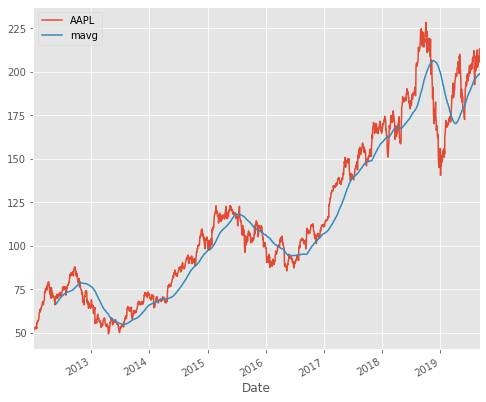

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

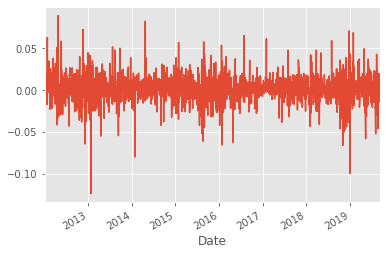

In [4]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [5]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.head()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2012-01-03,51.269413,13.666215,331.462585,143.065247,22.156071
2012-01-04,51.544937,13.815087,332.892242,142.481613,22.677486
2012-01-05,52.117188,13.807643,328.274536,141.805878,22.909233
2012-01-06,52.662014,13.882080,323.796326,140.177872,23.265116
2012-01-09,52.578468,14.038386,310.067780,139.448303,22.958887


In [6]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.256907,0.418463,0.332881,0.428567
GE,0.256907,1.000000,0.277525,0.376440,0.285409
GOOG,0.418463,0.277525,1.000000,0.368219,0.531283
IBM,0.332881,0.376440,0.368219,1.000000,0.445760
MSFT,0.428567,0.285409,0.531283,0.445760,1.000000


Text(0, 0.5, 'Returns GE')

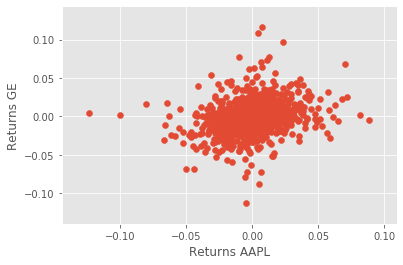

In [7]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

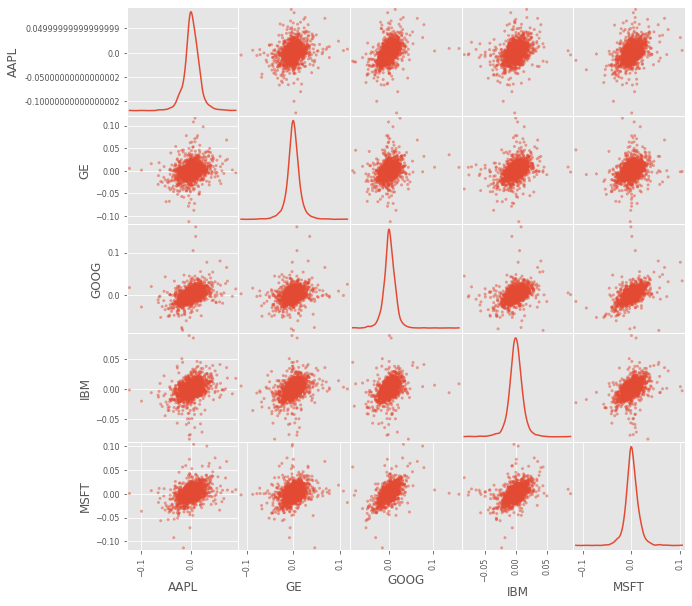

In [8]:
from pandas.plotting import scatter_matrix
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

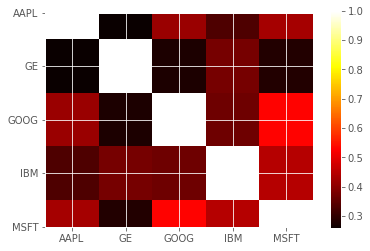

In [9]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

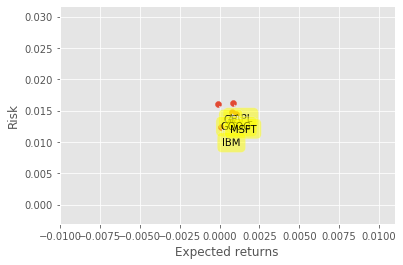

In [10]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [11]:
df.loc[:,['Adj Close','Volume']].head()

,Adj Close,Volume
Date,,
2012-01-03,51.269413,75555200.0
2012-01-04,51.544937,65005500.0
2012-01-05,52.117188,67817400.0
2012-01-06,52.662014,79573200.0
2012-01-09,52.578468,98506100.0


In [12]:
#Feature Engineering
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2012-01-03,51.269413,75555200.0,0.851105,0.446996
2012-01-04,51.544937,65005500.0,1.306119,0.839024
2012-01-05,52.117188,67817400.0,1.406598,0.742256
2012-01-06,52.662014,79573200.0,0.835698,0.626532
2012-01-09,52.578468,98506100.0,1.517562,-0.886015


In [15]:
import math

forecast_out = int(math.ceil(0.01 * len(dfreg)))
print(forecast_out)
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
#dfreg[:-forecast_out].head()
dfreg.head()
#dfreg[forecast_col].head()
#dfreg[forecast_col].shift(-forecast_out).head()

20


,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2012-01-03,51.269413,75555200.0,0.851105,0.446996
2012-01-04,51.544937,65005500.0,1.306119,0.839024
2012-01-05,52.117188,67817400.0,1.406598,0.742256
2012-01-06,52.662014,79573200.0,0.835698,0.626532
2012-01-09,52.578468,98506100.0,1.517562,-0.886015


In [19]:
import numpy as np
from sklearn import preprocessing

forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

X_lately = X[-forecast_out:]

#X[:-forecast_out]

In [20]:
import math
import numpy as np



# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

(1932, 5)
Dimension of X (1912, 4)
Dimension of y (1912,)


In [21]:
!pip install sklearn

In [22]:
import math
import numpy as np
from sklearn.model_selection import train_test_split

# Separation of training and testing of model by cross validation train test split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
# Model generation
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [24]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [25]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [26]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)


In [27]:

# Printing the forecast

forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set,  forecast_out)

[201.34232075 200.94713318 206.50315886 202.67180417 201.69117377
 206.53373993 210.640121   210.53447741 213.0800364  212.59897742
 201.22630027 206.88534896 204.2935164  206.12353726 209.38843345
 209.11441784 206.2311761  209.69180383 213.47563205 213.79389026] 20


In [28]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

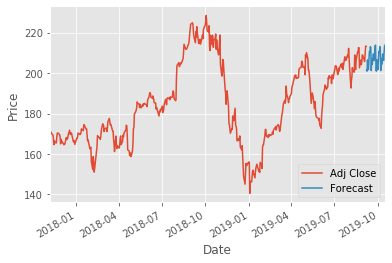

In [29]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()